# Segregação do In em poços quânticos de $In_x Ga_{1-x} As$ sobre $GaAs$

Abaixo estão as bibliotecas e configurações utilizadas.

In [2]:
# load libraries and set plot parameters
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

import scipy.constants as cte
from scipy.signal import gaussian
from scipy.special import legendre
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.integrate import simps
from scipy.optimize import newton
from scipy.interpolate import interp1d

# constantes
au_l   = cte.value('atomic unit of length')
au_t   = cte.value('atomic unit of time')
au_e   = cte.value('atomic unit of energy')
ev     = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev  = au_e / ev

## Parâmetros Macro

In [3]:
N      = 2048
z_ang  = np.linspace(-250.0, 250.0, N) # Angstrom
z_au   = z_ang / au2ang

## Funções para obtenção de níveis de energia

In [4]:
def fi(v, i):
    """
    short for flex_index, find the index i in array v
    i might be float, so that for i = 1.5, returns
    (v[2]+v[1])/2
    """
    if i < 0.0:
        return v[0]
    elif i >= len(v) - 1:
        return v[-1]
    
    try:
        i_up   = int(np.ceil(i))
        i_down = int(np.floor(i))
        return (v[i_up]+v[i_down])/2.0
    except:
        return 0.0
    
def eigenvalue(z, V, psi, m):
    """
    calculate eigenvalue like E=<Psi|H|Psi>/<Psi|Psi>
    """
    dz    = z[1]-z[0]
    dz2   = dz**2
    h_psi = np.zeros(N, dtype=np.complex_)
    
    for i in range(N):
        h_psi[i] = ((0.5/dz2)*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5))+V[i])*psi[i]
        
        if i > 0:
            h_psi[i] += -(0.5/dz2)*(psi[i-1]/fi(m,i-0.5))
            
        if i < N-1:
            h_psi[i] += -(0.5/dz2)*(psi[i+1]/fi(m,i+0.5))
            
    psi_h_psi = simps(psi.conj()*h_psi, z)
    return (psi_h_psi / simps(psi.conj()*psi, z)).real
    
    
def fundamental(z, V, m):
    """
    finds the fundamental state under potential V for coordinate
    space z and effective mass m
    everything is expected to be in atomic units
    """
    
    dz  = z[1]-z[0]
    dz2 = dz**2
    
    # kick start function
    psi       = np.array(gaussian(N, std=int(N/100)), dtype=np.complex_)
    psi      /= np.sqrt(simps(psi.conj()*psi,z))
    
    sub_diag  = np.zeros(N-1, dtype=np.complex_)
    main_diag = np.zeros(N  , dtype=np.complex_)

    for i in range(N):
        try:
            main_diag[i] = (0.5/dz2)*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5))+V[i]
        except:
            main_diag[i] = 0.0
        
        if i < N-1:
            sub_diag[i] = -(0.5/dz2)*(1.0/fi(m,i+0.5))
    
    diagonals = [main_diag, sub_diag, sub_diag]
    A         = diags(diagonals, [0, -1, 1]).toarray()
    invA      = inv(A)
    
    counter   = 0
    precision = 1.0
    lastval   = 100.0
    eigenval  = 0.0
    
    while True:
        counter  += 1
        psi       = invA.dot(psi)
        #psi      /= np.sqrt(simps(psi.conj()*psi, z))
        eigenval  = eigenvalue(z, V, psi, m)
        precision = np.abs(1-eigenval/lastval)
        lastval   = eigenval
        
        if precision < 1e-8:
            break
        
    
    return {
        'eigenvalue': eigenval,
        'eigenvector': psi
    }

## Aplicação ao nível fundamental de um poço de $Al_x Ga_{1-x} As/GaAs$

Vamos aplicar as funções acima à um poço de $Al_x Ga_{1-x} As/GaAs$ com $x=0.0$ dentro do poço e $x=0.2$ nas barreiras e largura de $80$ Å. A fórmula para o GAP a $0 K$ é dada por:

$$E_g (x) = 1.519+1.447x -0.15 x^2 \,\,\,\, (eV)$$

No caso:

$$E_g(0.0) = 1,519 \,\,\,\, (eV)$$
$$E_g(0.2) = 1,8024 \,\,\,\, (eV)$$

O GAP do Vamos escolher o *band offset* como $70\%$ da diferença de GAP para a banda de condução e $30\%$ para a banda de valência. Como na figura à seguir:

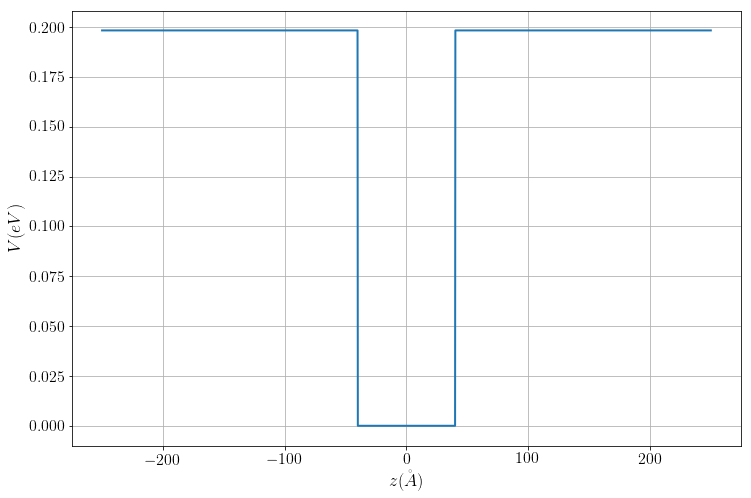

In [5]:
g_algaas = lambda x: 1.519+1.447*x-0.15*x**2 # GAP
m_algaas = lambda x: 0.067+0.083*x # effective mass
x_b      = 0.2 # barrier
x_w      = 0.0 # well
wl       = 80.0 # Angstrom
VBO      = 0.3
CBO      = 0.7
v_shape  = lambda z: g_algaas(x_b) if np.abs(z) > wl/2 else g_algaas(x_w)
m_shape  = lambda z: m_algaas(x_b) if np.abs(z) > wl/2 else m_algaas(x_w)
V        = np.vectorize(v_shape)(z_ang)*CBO
V       -= np.min(V)
meff     = np.vectorize(m_shape)(z_ang)

fig, ax = plt.subplots()
ax.set_xlabel(r'$z (\AA)$')
ax.set_ylabel(r'$V (eV)$')
ax.plot(z_ang, V)
ax.grid(True)
plt.show()

Nosso potencial está em $eV$, vamos converter ele para unidades atômicas, fazendo o mesmo para o vetor de coordenadas.

In [6]:
V_au = V / au2ev
z_au = z_ang / au2ang

Vamos agora calcular o primeiro nível de energia

In [7]:
res = fundamental(z_au, V_au, meff)
value  = res['eigenvalue'] * au2ev # in eV

# change from au to ang
vector  = res['eigenvector']
vector /= np.sqrt(simps(vector.conj()*vector, z_ang))

print(r"E0 = %.4f eV" % value)

E0 = 0.0398 eV


A solução analítica para esse potencial pode ser obtida a para

$$
\tan \left( \sqrt{\frac{a^2 m_e^* E_n}{2 \hbar^2}} \right) = \sqrt{\frac{(V_b-E_n)}{E_n}}
$$

$$
\cot \left( \sqrt{\frac{a^2 m_e^* E_n}{2 \hbar^2}} \right) = -\sqrt{\frac{(V_b-E_n)}{E_n}}
$$

Onde $a=80$ Å e $V_b=0.7 \times (E_g(0.2)-E_g(0.0))$. Para a solução analítica, adotamos $m_e^*$ como sendo a massa efetiva do elétron dentro do poço, ou seja, a massa efetiva do $GaAs$ ($0.067$).

In [8]:
import warnings
warnings.filterwarnings('error')

m_eff = 0.067
wl_au = wl / au2ang
vb_au = np.ptp(V_au)

trans_tan = lambda e: np.tan(
        np.sqrt(2*m_eff*e)*wl_au/2
    ) - np.sqrt(vb_au/e - 1.0)

trans_tan_der = lambda e: 1.0 / np.cos(
        np.sqrt(2*m_eff*e)*wl_au/2
    )**2 * (
        m_eff * wl_au / (2 * np.sqrt(2*m_eff*e))
    ) + vb_au / (2.0 * e**2 * np.sqrt(vb_au/e - 1.0))

trans_cot = lambda e: 1.0 / np.tan(
        np.sqrt(2*m_eff*e)*wl_au/2
    ) + np.sqrt(vb_au/e - 1.0)

trans_cot_der = lambda e: -1.0 / np.sin(
        np.sqrt(2*m_eff*e)*wl_au/2
    )**2 * (
        m_eff * wl_au / (2 * np.sqrt(2*m_eff*e))
    ) - vb_au / (2.0 * e**2 * np.sqrt(vb_au/e - 1.0))

t_functions = [
    (trans_tan,trans_tan_der),
    (trans_cot, trans_cot_der)
]

# kickstart energies values
energies = np.linspace(-0.1*vb_au, 1.1*vb_au, 10000)
eigenvalues = []
for f,fp in t_functions:
    for e0 in energies:
        try:
            root = newton(f, x0=e0, fprime=fp)
            if root > 0:
                eigenvalues.append(root * au2ev)
        except:
            pass

eigenvalues = np.array(list(sorted(set(eigenvalues))))

# eigenvalues at this point is a huge list with almost
# 2000 elements, many of them almost the same, duo to 
# kickstart values leading to the same eigenvalue 
# the code bellow identifies the proper ranges and get the
# average of each, actually, the difference is only
# the numerical error, which is about 1e-11 eV for an 
# eigenvalue of order 0.01 eV
offset = [0]
for i in range(1, eigenvalues.size):
    if np.abs(eigenvalues[i] / \
            np.average(eigenvalues[offset[-1]:i])-1.0) > 0.01:
        offset.append(i)
offset.append(len(eigenvalues))
eigenvalues = [np.average(eigenvalues[offset[i]:offset[i+1]]) \
    for i in range(len(offset)-1)]

for i, eigen in enumerate(eigenvalues):
    print("E%d = %.4f eV" % (i, eigen))

E0 = 0.0423 eV
E1 = 0.1526 eV


Vemos que o primeiro autovalor analítico está em grande acordo com o valor obtido numericamente.

$$
\Delta \approx 0.0423 - 0.0398 = 0.0025 eV
$$

Vale lembrar ainda que enquanto o método numérico enxerga a massa efetiva diferente do lado de fora do poço, a solução analítica só vale para uma massa efetiva constante dentro e fora do poço.

## PL do $In_{0.14} Ga_{0.86} As$ sobre $GaAs$

Vamos agora passo a passo tentar reproduzir os valores obtidos experimentalmente.

Amostra crescida a 475 °C e PL medida a 77 K:

> ML=10, PL= 1.43681 eV

> ML=15, PL= 1.40565 ev

> ML=21, PL= 1.38018 eV

> ML=28, PL= 1.36112 eV

Amostra crescida a 525 °C e PL medida a 77 K:

> ML=10, PL= 1.45091 eV

> ML=15, PL= 1.42051 ev

> ML=21, PL= 1.39425 eV

> ML=28, PL= 1.37454 ev

Onde ML é abreviação de Monolayers (metade do parametro de rede).

Apenas para fins de comparação gradual:

In [9]:
samples = {
    'ml': [10, 15, 21, 28],
    475: [1.43681, 1.40565, 1.38018, 1.36112],
    525: [1.45091, 1.42051, 1.39425, 1.37454]
}

def sample_skeleton():
    return {
        'ml': [10, 15, 21, 28],
        475: [0, 0, 0, 0],
        525: [0, 0, 0, 0]
    }

R_T = {
    525: 0.867,
    475: 0.778
}

x0 = 0.14 # indended indium concentration

pl_numeric = {}

Vamos começar com um poço de $InGaAs$ simples. Sendo GAP do $In_x Ga_{1-x} As$ a $2$ K dado por:

$$
E_g (x) = 1.522-1.1 x +0.4 x^2 \,\,\,\, eV
$$

Além disso, as massas efetivas do elétron e do buraco pesado na direção de crescimento (respectivamente) são dadas por:

$$
1/ m_e (x) = x/0.023 + (1-x)/0.067   \\
1/ m_{hh_z} (x) = x/0.263 + (1-x)/0.333
$$

Por fim, o parâmetro de rede é dado por:

$$
a_0 (x) = 6.0584 x + 5.6533 (1-x) \,\,\,\, Å
$$

In [10]:
eg_2 = lambda x: 1.522-1.1*x+0.4*x**2
me   = lambda x: 1.0/(x/0.023+(1-x)/0.067)
mhh  = lambda x: 1.0/(x/0.263+(1-x)/0.333)
a0   = lambda x: 6.0584*x + 5.6533*(1-x)

Este potencial simplificado fica dado por:

In [11]:
# saving values for future comparison
pl_numeric['very_simple'] = sample_skeleton()

m_ingaas = lambda x: 0.067+0.083*x # effective mass
x_b      = 0.0 # barrier
x_w      = 0.14 # well
VBO      = 0.3
CBO      = 0.7
z_ang    = np.linspace(-250.0, 250.0, N) # Angstrom
z_au     = z_ang / au2ang # atomic units
wl_lens  = [(a0(x0)/2.0) * nl for nl in samples['ml']]

for i, ml in enumerate(samples['ml']):
    wl = (a0(x0)/2.0) * ml
    v_shape   = lambda z: eg_2(x_b) if np.abs(z) > wl/2 else eg_2(x_w)
    me_shape  = lambda z: me(x_b) if np.abs(z) > wl/2 else me(x_w)
    mhh_shape = lambda z: mhh(x_b) if np.abs(z) > wl/2 else mhh(x_w)
    
    Vc        = np.vectorize(v_shape)(z_ang)*CBO
    Vv        = np.vectorize(v_shape)(z_ang)*VBO
    Vc_red    = Vc-np.min(Vc)
    Vv_red    = Vv-np.min(Vv)
    Vc_au     = Vc_red / au2ev
    Vv_au     = Vv_red / au2ev
    
    me_eff    = np.vectorize(me_shape)(z_ang)
    mhh_eff   = np.vectorize(mhh_shape)(z_ang)
  
    GAP       = np.min(Vc+Vv)
    res_e     = fundamental(z_au, Vc_au, me_eff)
    eigen_e   = res_e['eigenvalue'] * au2ev # in eV
    res_hh    = fundamental(z_au, Vv_au, mhh_eff)
    eigen_hh  = res_hh['eigenvalue'] * au2ev # in eV

    PL = GAP + eigen_e + eigen_hh
    
    pl_numeric['very_simple'][475][i] = PL
    pl_numeric['very_simple'][525][i] = PL
    
    print("ML = %d, PL(475) = %.4f, PL(525) = %.4f, PL_num = %.4f" % (ml, samples[475][i], samples[525][i], PL))

ML = 10, PL(475) = 1.4368, PL(525) = 1.4509, PL_num = 1.4800
ML = 15, PL(475) = 1.4057, PL(525) = 1.4205, PL_num = 1.4559
ML = 21, PL(475) = 1.3802, PL(525) = 1.3942, PL_num = 1.4357
ML = 28, PL(475) = 1.3611, PL(525) = 1.3745, PL_num = 1.4200


Apesar de os valores numéricos acima estarem bastante diferentes dos valores experimentais, é impressionante o quão próximos else estão (mesmo ignorando praticamente todos os efeitos que estão por vir na sequência).

## Efeitos de Segregação

Vamos começar a melhorar nosso modelo incluindo logo de cara a segregação.

In [12]:
def in_segregation(x0, R, n, N=None):
    """
    return the actual indium concentration in the nth layer

    Params
    ------
    x0 : float
        the indium concentration between 0 and 1
    R : float
        the segregation coefficient
    n : int
        the current layer
    N : int
        number of layers in the well
    """
    if N:
        return x0*(1-R**N)*R**(n-N)
    return x0*(1-R**n)

O poço será construído para cada número de monolayers e envolvido em $250$ Å de cada lado.

In [13]:
def x_grid(ml, x0, R):
    """
    for a given number of intendend monolayers inside the well
    return the indium concentration in each layer plus some
    layers that will have indium in the barrier
    """
    i = 0
    x_grid = []
    while True:
        i += 1
        if i > ml:
            in_x = in_segregation(x0, R, i, ml)
        else:
            in_x = in_segregation(x0, R, i)

        if in_x < 0.0001:
            break
        x_grid.append(in_x)
    return x_grid

Exemplo, para 10 monolayers, $x=0.14$ e $R=0.9$:        

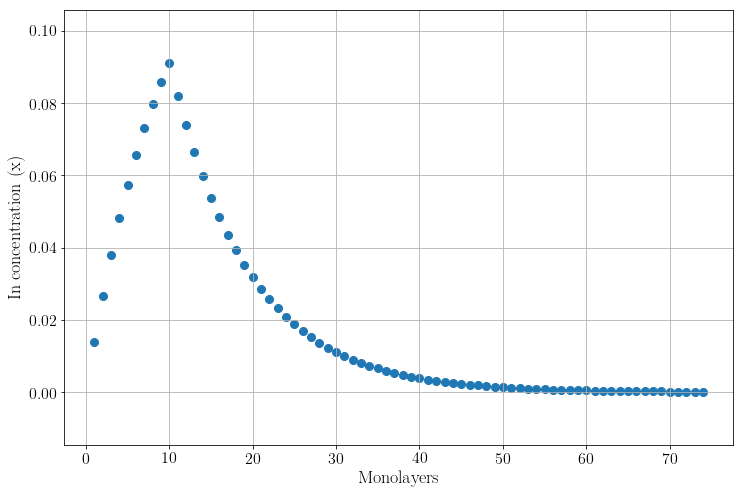

In [14]:
example_x_grid = x_grid(10, 0.14, 0.9)
fig, ax = plt.subplots()
ax.scatter(range(len(example_x_grid)+1)[1:], example_x_grid)
ax.grid(True)
ax.set_xlabel('Monolayers')
ax.set_ylabel('In concentration (x)')
plt.show()

Então nós conseguimos calcular a concentração em cada monolayer. Vamos agora gerar um grid de coordenadas z tal que o poço como o da figura acima ainda tenha $250$ Å de cada lado.

In [15]:
# saving values for future comparison
pl_numeric['segregation_only'] = sample_skeleton()
for i, ml in enumerate(samples['ml']):
    for T, R in R_T.items():
        x_well     = x_grid(ml, x0, R)
        x_barrier  = [0.0] * int(250.0 / a0(0.0))
        
        x_total    = x_barrier+x_well+x_barrier
        sys_len    = np.sum([a0(x) for x in x_total])
        z_temp     = np.linspace(-sys_len/2,sys_len/2,len(x_total))
        z_ang_in   = np.linspace(-sys_len/2,sys_len/2,N)
        f1         = interp1d(z_temp, x_total, kind='nearest')
        x_total    = f1(z_ang_in)
        
        z_au_in    = z_ang_in / au2ang
        me_in      = np.vectorize(me)(x_total)
        mhh_in     = np.vectorize(mhh)(x_total)
        v_shape_in = np.vectorize(eg_2)(x_total)
        
        Vc         = v_shape_in*CBO
        Vv         = v_shape_in*VBO
        Vc_red     = Vc-np.min(Vc)
        Vv_red     = Vv-np.min(Vv)
        Vc_au      = Vc_red / au2ev
        Vv_au      = Vv_red / au2ev

        GAP        = np.min(Vc+Vv)
        res_e      = fundamental(z_au_in, Vc_au, me_in)
        eigen_e    = res_e['eigenvalue'] * au2ev # in eV
        res_hh     = fundamental(z_au_in, Vv_au, mhh_in)
        eigen_hh   = res_hh['eigenvalue'] * au2ev # in eV

        PL = GAP + eigen_e + eigen_hh
    
        pl_numeric['segregation_only'][T][i] = PL
        print("T = %d C, R = %.4f, ML = %d, PL = %.4f, PL_num = %.4f" % (T, R, ml, samples[T][i], PL))
        

T = 525 C, R = 0.8670, ML = 10, PL = 1.4509, PL_num = 1.4663
T = 475 C, R = 0.7780, ML = 10, PL = 1.4368, PL_num = 1.4542
T = 525 C, R = 0.8670, ML = 15, PL = 1.4205, PL_num = 1.4418
T = 475 C, R = 0.7780, ML = 15, PL = 1.4057, PL_num = 1.4290
T = 525 C, R = 0.8670, ML = 21, PL = 1.3942, PL_num = 1.4216
T = 475 C, R = 0.7780, ML = 21, PL = 1.3802, PL_num = 1.4108
T = 525 C, R = 0.8670, ML = 28, PL = 1.3745, PL_num = 1.4067
T = 475 C, R = 0.7780, ML = 28, PL = 1.3611, PL_num = 1.3987


Agora já é possível ver uma grande melhora só adicionando a segregação:

[]

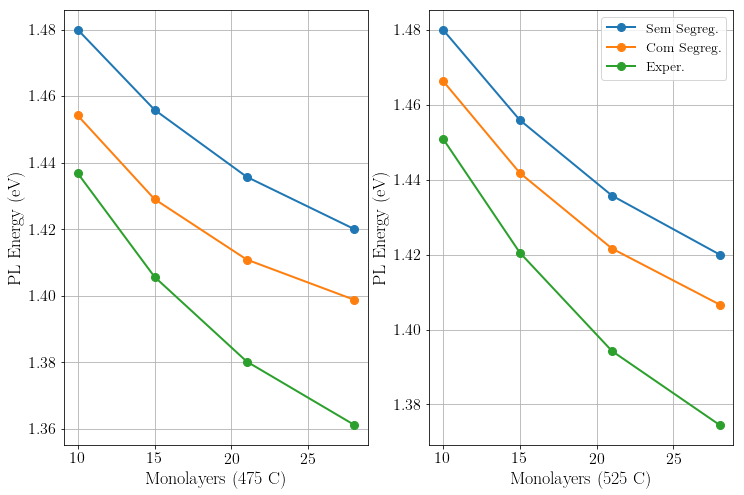

In [16]:
pl_simple_475 = pl_numeric['very_simple'][475]
pl_simple_525 = pl_numeric['very_simple'][525]
pl_segreg_475 = pl_numeric['segregation_only'][475]
pl_segreg_525 = pl_numeric['segregation_only'][525]
pl_experi_475 = samples[475]
pl_experi_525 = samples[525]
ml_grid       = samples['ml']

fig, (ax1, ax2) = plt.subplots(1,2)

sim475, = ax1.plot(ml_grid, pl_simple_475, '-o', label='Sem segregação')
seg475, = ax1.plot(ml_grid, pl_segreg_475, '-o', label='Com segregação')
exp475, = ax1.plot(ml_grid, pl_experi_475, '-o', label='Experimental')
ax1.grid(True)
ax1.set_xlabel('Monolayers (475 C)')
ax1.set_ylabel('PL Energy (eV)')

sim525, = ax2.plot(ml_grid, pl_simple_525, '-o', label='Sem segregação')
seg525, = ax2.plot(ml_grid, pl_segreg_525, '-o', label='Com segregação')
exp525, = ax2.plot(ml_grid, pl_experi_525, '-o', label='Experimental')
ax2.grid(True)
ax2.set_xlabel('Monolayers (525 C)')
ax2.set_ylabel('PL Energy (eV)')

plt.legend([sim475, seg475, exp475], ['Sem Segreg.','Com Segreg.','Exper.'], loc='best')
plt.plot()

## Ajustando *GAP* para $77$ K

Até agora utilizamos o *GAP* do material a $0$ K, vamos utilizar esta expressão à seguir que vale para o $In_{1-x} Ga_x As$:

$$
E_g (x,T) = 0.42 + 0.625 x - \left(\frac{5.8}{T+300} - \frac{4.9}{T+271} \right) 10^{-4} T^2 x - 4.19 \, 10^{-4} \frac{T^2}{T+271} + 0.475 x^2 \,\,\,\, (eV)
$$

apenas para ter uma noção do comportamento dessa expressão, mostramos a seguir para $x=0.10$, $x=0.15$ e $x=0.20$.

**Já vamos trocar tudo que for $x$ por $1-x$ e vice-versa, pois a fórmula acima vale para $In_{1-x} Ga_x As$.**

[]

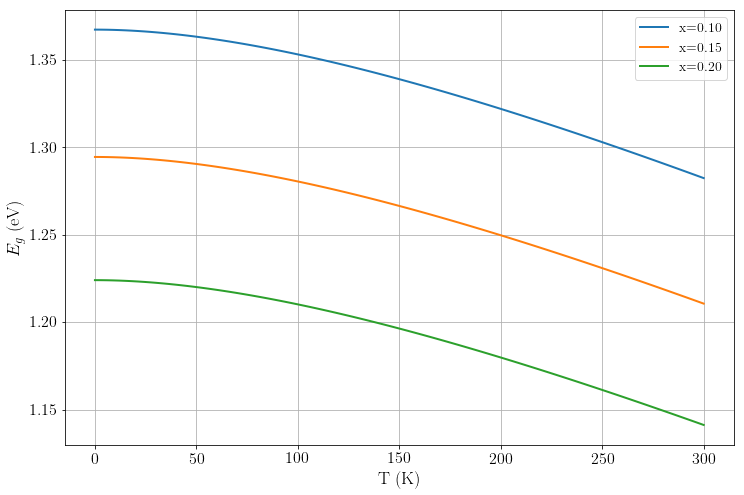

In [17]:
eg_xt_ingaas = lambda x,T: 0.42+0.625*(1-x)-(5.8/(T+300)-4.19/(T+271))*1e-4*(T**2)*(1-x) - 4.19e-4 * ((T**2)/(T+271))+0.475*(1-x)**2

T_range = np.linspace(0,300,100)
eg_10_t_ingaas = np.vectorize(eg_xt_ingaas)(100*[0.10], T_range)
eg_15_t_ingaas = np.vectorize(eg_xt_ingaas)(100*[0.15], T_range)
eg_20_t_ingaas = np.vectorize(eg_xt_ingaas)(100*[0.20], T_range)

fig, ax = plt.subplots()

x10, = ax.plot(T_range, eg_10_t_ingaas)
x15, = ax.plot(T_range, eg_15_t_ingaas)
x20, = ax.plot(T_range, eg_20_t_ingaas)
ax.grid(True)
ax.set_xlabel('T (K)')
ax.set_ylabel('$E_g$ (eV)')

plt.legend([x10, x15, x20], ['x=0.10','x=0.15','x=0.20'], loc='best')
plt.plot()

In [18]:
# saving values for future comparison
pl_numeric['segregation_temp'] = sample_skeleton()
for i, ml in enumerate(samples['ml']):
    for T, R in R_T.items():
        x_well     = x_grid(ml, x0, R)
        x_barrier  = [0.0] * int(250.0 / a0(0.0))
        
        x_total    = x_barrier+x_well+x_barrier
        sys_len    = np.sum([a0(x) for x in x_total])
        z_temp     = np.linspace(-sys_len/2,sys_len/2,len(x_total))
        z_ang_in   = np.linspace(-sys_len/2,sys_len/2,N)
        f1         = interp1d(z_temp, x_total, kind='nearest')
        x_total    = f1(z_ang_in)
        
        z_au_in    = z_ang_in / au2ang
        me_in      = np.vectorize(me)(x_total)
        mhh_in     = np.vectorize(mhh)(x_total)
        v_shape_in = np.vectorize(eg_xt_ingaas)(x_total, len(x_total)*[77])
        
        Vc         = v_shape_in*CBO
        Vv         = v_shape_in*VBO
        Vc_red     = Vc-np.min(Vc)
        Vv_red     = Vv-np.min(Vv)
        Vc_au      = Vc_red / au2ev
        Vv_au      = Vv_red / au2ev

        GAP        = np.min(Vc+Vv)
        res_e      = fundamental(z_au_in, Vc_au, me_in)
        eigen_e    = res_e['eigenvalue'] * au2ev # in eV
        res_hh     = fundamental(z_au_in, Vv_au, mhh_in)
        eigen_hh   = res_hh['eigenvalue'] * au2ev # in eV

        PL = GAP + eigen_e + eigen_hh
    
        pl_numeric['segregation_temp'][T][i] = PL
        print("T = %d C, R = %.4f, ML = %d, PL = %.4f, PL_num = %.4f" % (T, R, ml, samples[T][i], PL))

T = 525 C, R = 0.8670, ML = 10, PL = 1.4509, PL_num = 1.4223
T = 475 C, R = 0.7780, ML = 10, PL = 1.4368, PL_num = 1.4020
T = 525 C, R = 0.8670, ML = 15, PL = 1.4205, PL_num = 1.3866
T = 475 C, R = 0.7780, ML = 15, PL = 1.4057, PL_num = 1.3664
T = 525 C, R = 0.8670, ML = 21, PL = 1.3942, PL_num = 1.3583
T = 475 C, R = 0.7780, ML = 21, PL = 1.3802, PL_num = 1.3421
T = 525 C, R = 0.8670, ML = 28, PL = 1.3745, PL_num = 1.3382
T = 475 C, R = 0.7780, ML = 28, PL = 1.3611, PL_num = 1.3267


Vemos que este ajuste abaixou demais os níveis:

[]

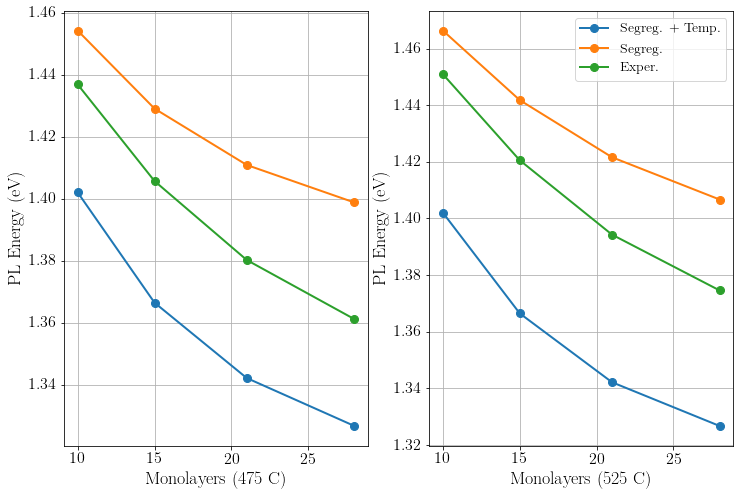

In [19]:
pl_segtem_475 = pl_numeric['segregation_temp'][475]
pl_segtem_525 = pl_numeric['segregation_temp'][525]
pl_segreg_475 = pl_numeric['segregation_only'][475]
pl_segreg_525 = pl_numeric['segregation_only'][525]
pl_experi_475 = samples[475]
pl_experi_525 = samples[525]
ml_grid       = samples['ml']

fig, (ax1, ax2) = plt.subplots(1,2)

sim475, = ax1.plot(ml_grid, pl_segtem_475, '-o')
seg475, = ax1.plot(ml_grid, pl_segreg_475, '-o')
exp475, = ax1.plot(ml_grid, pl_experi_475, '-o')
ax1.grid(True)
ax1.set_xlabel('Monolayers (475 C)')
ax1.set_ylabel('PL Energy (eV)')

sim525, = ax2.plot(ml_grid, pl_segtem_475, '-o')
seg525, = ax2.plot(ml_grid, pl_segreg_525, '-o')
exp525, = ax2.plot(ml_grid, pl_experi_525, '-o')
ax2.grid(True)
ax2.set_xlabel('Monolayers (525 C)')
ax2.set_ylabel('PL Energy (eV)')

plt.legend([sim475, seg475, exp475], ['Segreg. + Temp.','Segreg.','Exper.'], loc='best')
plt.plot()

## Incluindo efeito da Tensão

Antes de fazermos a correção devido a tensão de forma correta. Vamos testar esta fórmula a seguir, que aparentemente já contempla os efeitos da tensão e da temperatura:

$$
E_g (x,T) = 1.321 - (6x^2-8.6x+5.2) \, 10^{-4} \, . \, \frac{T^2}{T+(377 x^2-455 x+196)} \,\,\,\, (eV)
$$

Como ela também vale para $In_{1-x} Ga_x As$ vamos trocar tudo que for $x$ por $1-x$. 

[]

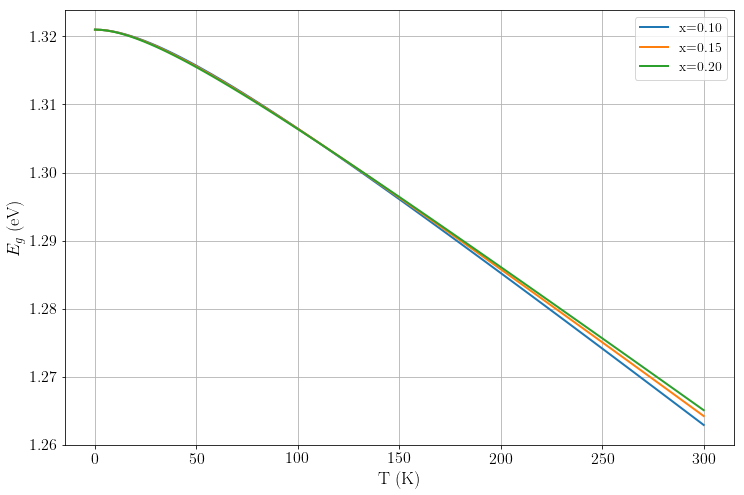

In [20]:
eg_xt_ingaas_strain = lambda x,T: 1.321-(6*(1-x)**2-8.6*(1-x)+5.2)*1e-4*((T**2)/(T+(337*(1-x)**2-455*(1-x)+196)))

T_range = np.linspace(0,300,100)
eg_10_t_ingaas = np.vectorize(eg_xt_ingaas_strain)(100*[0.10], T_range)
eg_15_t_ingaas = np.vectorize(eg_xt_ingaas_strain)(100*[0.15], T_range)
eg_20_t_ingaas = np.vectorize(eg_xt_ingaas_strain)(100*[0.20], T_range)

fig, ax = plt.subplots()

x10, = ax.plot(T_range, eg_10_t_ingaas)
x15, = ax.plot(T_range, eg_15_t_ingaas)
x20, = ax.plot(T_range, eg_20_t_ingaas)
ax.grid(True)
ax.set_xlabel('T (K)')
ax.set_ylabel('$E_g$ (eV)')

plt.legend([x10, x15, x20], ['x=0.10','x=0.15','x=0.20'], loc='best')
plt.plot()

In [21]:
# saving values for future comparison
pl_numeric['segregation_temp_strain_1'] = sample_skeleton()
for i, ml in enumerate(samples['ml']):
    for T, R in R_T.items():
        x_well     = x_grid(ml, x0, R)
        x_barrier  = [0.0] * int(250.0 / a0(0.0))
        
        x_total    = x_barrier+x_well+x_barrier
        sys_len    = np.sum([a0(x) for x in x_total])
        z_temp     = np.linspace(-sys_len/2,sys_len/2,len(x_total))
        z_ang_in   = np.linspace(-sys_len/2,sys_len/2,N)
        f1         = interp1d(z_temp, x_total, kind='nearest')
        x_total    = f1(z_ang_in)
        
        z_au_in    = z_ang_in / au2ang
        me_in      = np.vectorize(me)(x_total)
        mhh_in     = np.vectorize(mhh)(x_total)
        v_shape_in = np.vectorize(eg_xt_ingaas_strain)(x_total, len(x_total)*[77])
        
        Vc         = v_shape_in*CBO
        Vv         = v_shape_in*VBO
        Vc_red     = Vc-np.min(Vc)
        Vv_red     = Vv-np.min(Vv)
        Vc_au      = Vc_red / au2ev
        Vv_au      = Vv_red / au2ev

        GAP        = np.min(Vc+Vv)
        res_e      = fundamental(z_au_in, Vc_au, me_in)
        eigen_e    = res_e['eigenvalue'] * au2ev # in eV
        res_hh     = fundamental(z_au_in, Vv_au, mhh_in)
        eigen_hh   = res_hh['eigenvalue'] * au2ev # in eV

        PL = GAP + eigen_e + eigen_hh
    
        pl_numeric['segregation_temp_strain_1'][T][i] = PL
        print("T = %d C, R = %.4f, ML = %d, PL = %.4f, PL_num = %.4f" % (T, R, ml, samples[T][i], PL))

T = 525 C, R = 0.8670, ML = 10, PL = 1.4509, PL_num = 1.3120
T = 475 C, R = 0.7780, ML = 10, PL = 1.4368, PL_num = 1.3124
T = 525 C, R = 0.8670, ML = 15, PL = 1.4205, PL_num = 1.3119
T = 475 C, R = 0.7780, ML = 15, PL = 1.4057, PL_num = 1.3122
T = 525 C, R = 0.8670, ML = 21, PL = 1.3942, PL_num = 1.3118
T = 475 C, R = 0.7780, ML = 21, PL = 1.3802, PL_num = 1.3121
T = 525 C, R = 0.8670, ML = 28, PL = 1.3745, PL_num = 1.3118
T = 475 C, R = 0.7780, ML = 28, PL = 1.3611, PL_num = 1.3120


Bom, talvez esta fórmula não seja muito adequada. Pelo gráfico acima já foi possível ver que ela não indica grande diferença em função de $x$ para temperaturas menores do que $\sim 250$ K.

Vamos então introduzir nosso ajuste, a partir dos parâmetros à seguir.

In [22]:
a    = np.vectorize(lambda x: -6.08 *x+(1-x)* -8.33 )
b    = np.vectorize(lambda x: -1.55 *x+(1-x)* -1.90 )
c11  = np.vectorize(lambda x:  0.83 *x+(1-x)*  1.22 )
c12  = np.vectorize(lambda x:  0.45 *x+(1-x)*  0.57 )

In [23]:
# saving values for future comparison
pl_numeric['segregation_temp_strain_2'] = sample_skeleton()
for i, ml in enumerate(samples['ml']):
    for T, R in R_T.items():
        x_well     = x_grid(ml, x0, R)
        x_barrier  = [0.0] * int(250.0 / a0(0.0))
        
        x_total    = x_barrier+x_well+x_barrier
        sys_len    = np.sum([a0(x) for x in x_total])
        z_temp     = np.linspace(-sys_len/2,sys_len/2,len(x_total))
        z_ang_in   = np.linspace(-sys_len/2,sys_len/2,N)
        f1         = interp1d(z_temp, x_total, kind='nearest')
        x_total    = f1(z_ang_in)
        
        z_au_in    = z_ang_in / au2ang
        me_in      = np.vectorize(me)(x_total)
        mhh_in     = np.vectorize(mhh)(x_total)
        v_shape_in = np.vectorize(eg_xt_ingaas)(x_total, len(x_total)*[77])
        
        _a   = a(x_total)
        _b   = b(x_total)
        _c11 = c11(x_total)
        _c12 = c12(x_total)
        a0_vec  = np.vectorize(a0)
        
        _epp = (a0_vec([0])[0]-a0_vec(x_total))/a0_vec(x_total)
        v_shape_in = v_shape_in + (2*_a*(_c11-_c12)-_b*(_c11+2*_c12))*_epp/_c11
        
        Vc         = v_shape_in*CBO
        Vv         = v_shape_in*VBO
        Vc_red     = Vc-np.min(Vc)
        Vv_red     = Vv-np.min(Vv)
        Vc_au      = Vc_red / au2ev
        Vv_au      = Vv_red / au2ev

        GAP        = np.min(Vc+Vv)
        res_e      = fundamental(z_au_in, Vc_au, me_in)
        eigen_e    = res_e['eigenvalue'] * au2ev # in eV
        res_hh     = fundamental(z_au_in, Vv_au, mhh_in)
        eigen_hh   = res_hh['eigenvalue'] * au2ev # in eV

        PL = GAP + eigen_e + eigen_hh
    
        pl_numeric['segregation_temp_strain_2'][T][i] = PL
        print("T = %d C, R = %.4f, ML = %d, PL = %.4f, PL_num = %.4f" % (T, R, ml, samples[T][i], PL))

T = 525 C, R = 0.8670, ML = 10, PL = 1.4509, PL_num = 1.4475
T = 475 C, R = 0.7780, ML = 10, PL = 1.4368, PL_num = 1.4331
T = 525 C, R = 0.8670, ML = 15, PL = 1.4205, PL_num = 1.4199
T = 475 C, R = 0.7780, ML = 15, PL = 1.4057, PL_num = 1.4050
T = 525 C, R = 0.8670, ML = 21, PL = 1.3942, PL_num = 1.3974
T = 475 C, R = 0.7780, ML = 21, PL = 1.3802, PL_num = 1.3850
T = 525 C, R = 0.8670, ML = 28, PL = 1.3745, PL_num = 1.3809
T = 475 C, R = 0.7780, ML = 28, PL = 1.3611, PL_num = 1.3719


Se é louco Cachoera!!!

[]

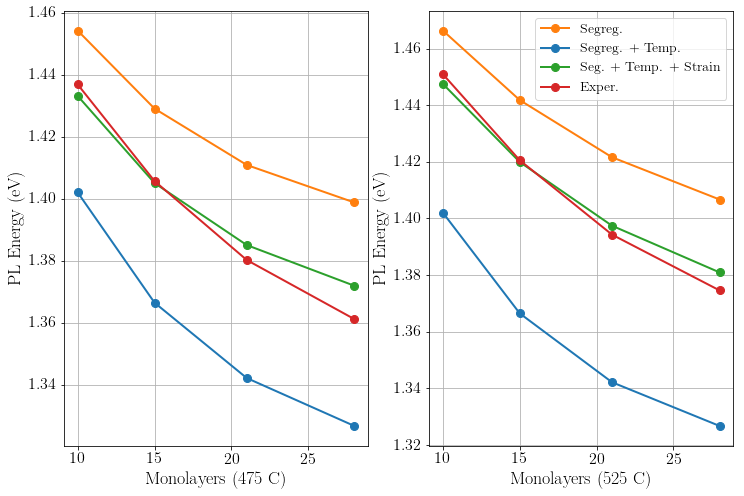

In [24]:
pl_segreg_475 = pl_numeric['segregation_only'][475]
pl_segreg_525 = pl_numeric['segregation_only'][525]

pl_segtem_475 = pl_numeric['segregation_temp'][475]
pl_segtem_525 = pl_numeric['segregation_temp'][525]

pl_segregstrain_475 = pl_numeric['segregation_temp_strain_2'][475]
pl_segregstrain_525 = pl_numeric['segregation_temp_strain_2'][525]

pl_experi_475 = samples[475]
pl_experi_525 = samples[525]
ml_grid       = samples['ml']

fig, (ax1, ax2) = plt.subplots(1,2)

sim475, = ax1.plot(ml_grid, pl_segtem_475, '-o')
seg475, = ax1.plot(ml_grid, pl_segreg_475, '-o')
segst475, = ax1.plot(ml_grid, pl_segregstrain_475, '-o')
exp475, = ax1.plot(ml_grid, pl_experi_475, '-o')
ax1.grid(True)
ax1.set_xlabel('Monolayers (475 C)')
ax1.set_ylabel('PL Energy (eV)')

sim525, = ax2.plot(ml_grid, pl_segtem_475, '-o')
seg525, = ax2.plot(ml_grid, pl_segreg_525, '-o')
segst525, = ax2.plot(ml_grid, pl_segregstrain_525, '-o')
exp525, = ax2.plot(ml_grid, pl_experi_525, '-o')
ax2.grid(True)
ax2.set_xlabel('Monolayers (525 C)')
ax2.set_ylabel('PL Energy (eV)')

plt.legend([seg475, sim475, segst475, exp475], ['Segreg.', 'Segreg. + Temp.', 'Seg. + Temp. + Strain', 'Exper.'], loc='best')
plt.plot()